In [1]:
# Notebook 3: Feature Engineering
# NIFTY Quantitative Trading System

"""
This notebook creates all required features:
1. EMA indicators (5, 15)
2. Options Greeks (Delta, Gamma, Theta, Vega, Rho)
3. IV-based features
4. PCR ratios
5. Derived features
"""

'\nThis notebook creates all required features:\n1. EMA indicators (5, 15)\n2. Options Greeks (Delta, Gamma, Theta, Vega, Rho)\n3. IV-based features\n4. PCR ratios\n5. Derived features\n'

In [2]:
import sys
!{sys.executable} -m pip install py_vollib


'c:\Users\Sanchit' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
%pip install py_vollib


Note: you may need to restart the kernel to use updated packages.


In [4]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Options pricing libraries
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks import analytical


In [5]:
# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_DIR = Path('../data')
CLEANED_DIR = DATA_DIR / 'cleaned'
FEATURES_DIR = DATA_DIR / 'features'
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

PLOTS_DIR = Path('../plots')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Risk-free rate (India 10Y bond yield ~6.5%)
RISK_FREE_RATE = 0.065

In [6]:
# ============================================================================
# LOAD CLEANED DATA
# ============================================================================

print("="*70)
print("LOADING CLEANED DATA")
print("="*70)

spot_df = pd.read_csv(CLEANED_DIR / 'nifty_spot_5min_clean.csv')
futures_df = pd.read_csv(CLEANED_DIR / 'nifty_futures_5min_clean.csv')
options_df = pd.read_csv(CLEANED_DIR / 'nifty_options_5min_clean.csv')

# Convert timestamps
for df in [spot_df, futures_df, options_df]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\n✓ Loaded Spot: {spot_df.shape}")
print(f"✓ Loaded Futures: {futures_df.shape}")
print(f"✓ Loaded Options: {options_df.shape}")


LOADING CLEANED DATA

✓ Loaded Spot: (28880, 7)
✓ Loaded Futures: (28880, 12)
✓ Loaded Options: (287533, 8)


In [7]:
# ============================================================================
# MERGE SPOT AND FUTURES
# ============================================================================

print("\n" + "="*70)
print("MERGING SPOT AND FUTURES DATA")
print("="*70)

# Merge spot and futures
merged_df = spot_df.merge(
    futures_df[['timestamp', 'close', 'open_interest']], 
    on='timestamp',
    suffixes=('_spot', '_futures')
)

print(f"✓ Merged dataset: {merged_df.shape}")



MERGING SPOT AND FUTURES DATA
✓ Merged dataset: (28880, 9)



TASK 2.1: CALCULATING EMA INDICATORS
  ✓ Calculated ema_5
  ✓ Calculated ema_15

✓ Saved: ema_indicators.png


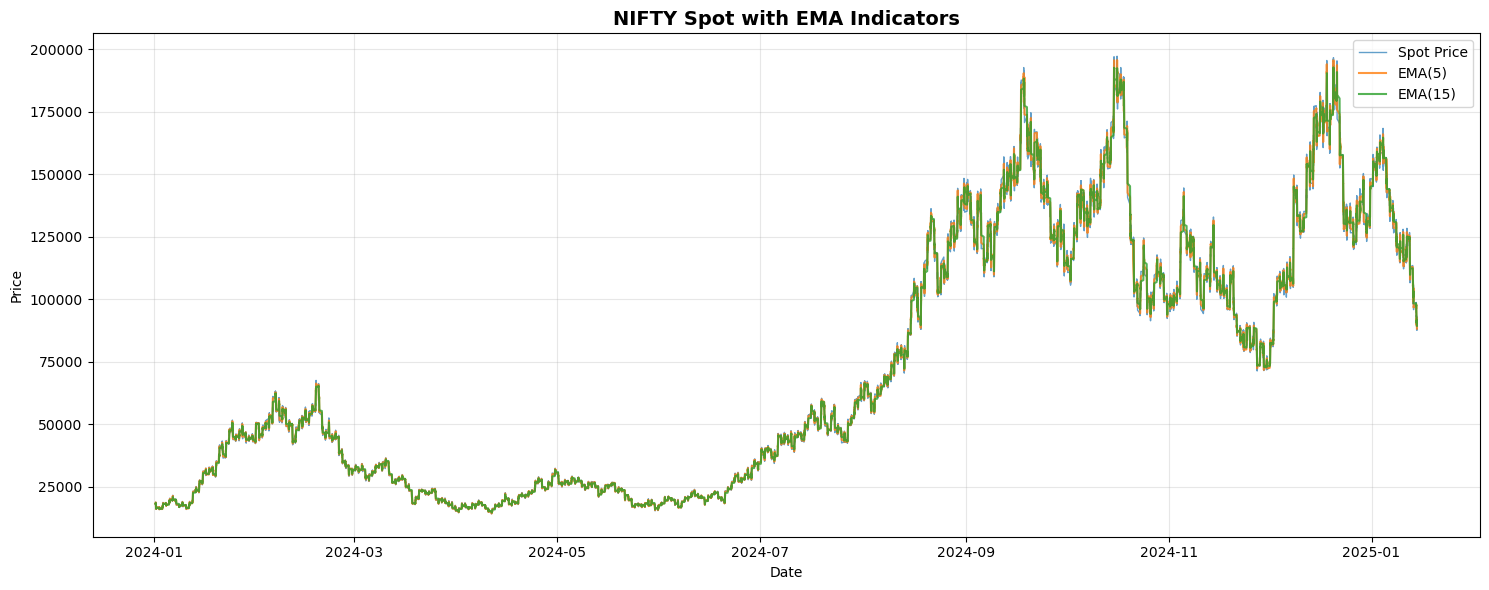

In [8]:
# ============================================================================
# TASK 2.1: EMA INDICATORS
# ============================================================================

print("\n" + "="*70)
print("TASK 2.1: CALCULATING EMA INDICATORS")
print("="*70)

def calculate_ema(df, column='close_spot', periods=[5, 15]):
    """Calculate Exponential Moving Averages"""
    for period in periods:
        col_name = f'ema_{period}'
        df[col_name] = df[column].ewm(span=period, adjust=False).mean()
        print(f"  ✓ Calculated {col_name}")
    return df

merged_df = calculate_ema(merged_df)

# Visualize EMAs
plt.figure(figsize=(15, 6))
plt.plot(merged_df['timestamp'], merged_df['close_spot'], 
         label='Spot Price', alpha=0.7, linewidth=1)
plt.plot(merged_df['timestamp'], merged_df['ema_5'], 
         label='EMA(5)', alpha=0.8, linewidth=1.5)
plt.plot(merged_df['timestamp'], merged_df['ema_15'], 
         label='EMA(15)', alpha=0.8, linewidth=1.5)
plt.title('NIFTY Spot with EMA Indicators', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'ema_indicators.png', dpi=300)
print(f"\n✓ Saved: ema_indicators.png")


In [9]:
# ============================================================================
# TASK 2.2: OPTIONS GREEKS
# ============================================================================

print("\n" + "="*70)
print("TASK 2.2: CALCULATING OPTIONS GREEKS")
print("="*70)

def calculate_time_to_expiry(current_date, expiry_date):
    """Calculate time to expiry in years"""
    if pd.isna(expiry_date):
        return 30/365  # Default 30 days
    days = (pd.to_datetime(expiry_date) - pd.to_datetime(current_date)).days
    return max(days / 365.0, 1/365)  # Minimum 1 day

def calculate_greeks(row, risk_free_rate=RISK_FREE_RATE):
    """Calculate all Greeks for an option"""
    try:
        S = row['close_spot']  # Spot price
        K = row['strike']       # Strike price
        T = calculate_time_to_expiry(row['timestamp'], row.get('expiry', None))
        sigma = row['iv']       # Implied volatility
        option_type = 'c' if row['option_type'] == 'CE' else 'p'
        
        # Calculate Greeks
        delta = analytical.delta(option_type, S, K, T, risk_free_rate, sigma)
        gamma = analytical.gamma(option_type, S, K, T, risk_free_rate, sigma)
        theta = analytical.theta(option_type, S, K, T, risk_free_rate, sigma)
        vega = analytical.vega(option_type, S, K, T, risk_free_rate, sigma)
        rho = analytical.rho(option_type, S, K, T, risk_free_rate, sigma)
        
        return pd.Series({
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho
        })
    except Exception as e:
        return pd.Series({
            'delta': np.nan,
            'gamma': np.nan,
            'theta': np.nan,
            'vega': np.nan,
            'rho': np.nan
        })

# Add spot price to options dataframe for Greeks calculation
options_with_spot = options_df.merge(
    spot_df[['timestamp', 'close']], 
    on='timestamp'
)
options_with_spot.rename(columns={'close': 'close_spot'}, inplace=True)

print("Calculating Greeks (this may take a few minutes)...")
greeks_df = options_with_spot.apply(calculate_greeks, axis=1)
options_with_greeks = pd.concat([options_with_spot, greeks_df], axis=1)

print(f"✓ Calculated Greeks for {len(options_with_greeks)} option records")
print("\nSample Greeks:")
print(options_with_greeks[['timestamp', 'strike', 'option_type', 
                           'delta', 'gamma', 'theta', 'vega', 'rho']].head())



TASK 2.2: CALCULATING OPTIONS GREEKS
Calculating Greeks (this may take a few minutes)...
✓ Calculated Greeks for 287533 option records

Sample Greeks:
            timestamp  strike option_type     delta     gamma     theta  \
0 2024-01-01 09:15:00   18000          CE  0.586651  0.000397 -8.167502   
1 2024-01-01 09:15:00   18000          PE -0.416548  0.000378 -5.313710   
2 2024-01-01 09:15:00   18050          CE  0.573113  0.000457 -7.387125   
3 2024-01-01 09:15:00   18050          PE -0.429914  0.000431 -4.523833   
4 2024-01-01 09:15:00   18100          CE  0.555221  0.000532 -6.617044   

        vega       rho  
0  20.201477  8.320647  
1  20.237119 -6.459226  
2  20.343034  8.181300  
3  20.371359 -6.637003  
4  20.492954  7.975300  


In [10]:
# ============================================================================
# TASK 2.3: DERIVED FEATURES
# ============================================================================

print("\n" + "="*70)
print("TASK 2.3: CALCULATING DERIVED FEATURES")
print("="*70)

# Group options by timestamp to calculate aggregate features

options_agg = options_with_greeks.groupby('timestamp').apply(
    lambda x: pd.Series({
        # Average IV
        'avg_iv': x['iv'].mean(),
        
        # IV Spread
        'iv_spread': x[x['option_type'] == 'CE']['iv'].mean() - 
                     x[x['option_type'] == 'PE']['iv'].mean(),
        
        # PCR (OI-based)
        'pcr_oi': x[x['option_type'] == 'PE']['open_interest'].sum() / 
                  max(x[x['option_type'] == 'CE']['open_interest'].sum(), 1),
        
        # PCR (Volume-based)
        'pcr_volume': x[x['option_type'] == 'PE']['volume'].sum() / 
                      max(x[x['option_type'] == 'CE']['volume'].sum(), 1),
        
        # ATM Greeks (strike_position == 0)
        'atm_call_delta': x[(x['option_type'] == 'CE') & 
                            (x['strike_position'] == 0)]['delta'].mean(),
        'atm_put_delta': x[(x['option_type'] == 'PE') & 
                           (x['strike_position'] == 0)]['delta'].mean(),
        'atm_gamma': x[x['strike_position'] == 0]['gamma'].mean(),
        'atm_theta': x[x['strike_position'] == 0]['theta'].mean(),
        'atm_vega': x[x['strike_position'] == 0]['vega'].mean(),
        
        # Total OI and Volume
        'total_call_oi': x[x['option_type'] == 'CE']['open_interest'].sum(),
        'total_put_oi': x[x['option_type'] == 'PE']['open_interest'].sum(),
        'total_call_volume': x[x['option_type'] == 'CE']['volume'].sum(),
        'total_put_volume': x[x['option_type'] == 'PE']['volume'].sum(),
    })
).reset_index()

print(f"✓ Calculated aggregate options features")

# Merge with main dataframe
merged_df = merged_df.merge(options_agg, on='timestamp', how='left')

# Calculate Futures Basis
merged_df['futures_basis'] = (
    (merged_df['close_futures'] - merged_df['close_spot']) / 
    merged_df['close_spot']
)
print("✓ Calculated Futures Basis")

# Calculate Returns
merged_df['returns_spot'] = merged_df['close_spot'].pct_change()
merged_df['returns_futures'] = merged_df['close_futures'].pct_change()
print("✓ Calculated Returns")

# Calculate Delta Neutral Ratio
merged_df['delta_neutral_ratio'] = (
    np.abs(merged_df['atm_call_delta']) / 
    np.abs(merged_df['atm_put_delta']).replace(0, np.nan)
)
print("✓ Calculated Delta Neutral Ratio")

# Calculate Gamma Exposure
merged_df['gamma_exposure'] = (
    merged_df['close_spot'] * 
    merged_df['atm_gamma'] * 
    (merged_df['total_call_oi'] + merged_df['total_put_oi'])
)
print("✓ Calculated Gamma Exposure")


TASK 2.3: CALCULATING DERIVED FEATURES
✓ Calculated aggregate options features
✓ Calculated Futures Basis
✓ Calculated Returns
✓ Calculated Delta Neutral Ratio
✓ Calculated Gamma Exposure


In [11]:
print(merged_df.columns.tolist())


['timestamp', 'open', 'high', 'low', 'close_spot', 'volume', 'atm_strike', 'close_futures', 'open_interest', 'ema_5', 'ema_15', 'avg_iv', 'iv_spread', 'pcr_oi', 'pcr_volume', 'atm_call_delta', 'atm_put_delta', 'atm_gamma', 'atm_theta', 'atm_vega', 'total_call_oi', 'total_put_oi', 'total_call_volume', 'total_put_volume', 'futures_basis', 'returns_spot', 'returns_futures', 'delta_neutral_ratio', 'gamma_exposure']


In [12]:
merged_df = merged_df.rename(columns={
    'high': 'high_spot',
    'low': 'low_spot',
    'volume': 'volume_spot'
})


In [13]:
# ============================================================================
# ADDITIONAL USEFUL FEATURES
# ============================================================================

print("\n" + "="*70)
print("CALCULATING ADDITIONAL FEATURES")
print("="*70)

# ATR (Average True Range)
merged_df['tr'] = np.maximum(
    merged_df['high_spot'] - merged_df['low_spot'],
    np.maximum(
        np.abs(merged_df['high_spot'] - merged_df['close_spot'].shift(1)),
        np.abs(merged_df['low_spot'] - merged_df['close_spot'].shift(1))
    )
)
merged_df['atr_14'] = merged_df['tr'].rolling(window=14).mean()
print("✓ Calculated ATR(14)")

# Volume indicators
merged_df['volume_sma_20'] = merged_df['volume_spot'].rolling(window=20).mean()
merged_df['volume_ratio'] = merged_df['volume_spot'] / merged_df['volume_sma_20']
print("✓ Calculated Volume Ratio")

# Momentum
merged_df['roc_10'] = (
    (merged_df['close_spot'] - merged_df['close_spot'].shift(10)) / 
    merged_df['close_spot'].shift(10) * 100
)
print("✓ Calculated Rate of Change (10)")

# EMA gap (signal strength)
merged_df['ema_gap'] = (
    (merged_df['ema_5'] - merged_df['ema_15']) / 
    merged_df['ema_15'] * 100
)
print("✓ Calculated EMA Gap")

# Time-based features
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df['minute'] = merged_df['timestamp'].dt.minute
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek
print("✓ Created Time Features")



CALCULATING ADDITIONAL FEATURES
✓ Calculated ATR(14)
✓ Calculated Volume Ratio
✓ Calculated Rate of Change (10)
✓ Calculated EMA Gap
✓ Created Time Features


In [14]:
# ============================================================================
# HANDLE MISSING VALUES IN FEATURES
# ============================================================================

print("\n" + "="*70)
print("HANDLING MISSING VALUES")
print("="*70)

print(f"Missing values before:\n{merged_df.isnull().sum()[merged_df.isnull().sum() > 0]}")

# Forward fill and then backward fill
merged_df = merged_df.fillna(method='ffill').fillna(method='bfill')

# Fill remaining with 0 (for derived features)
merged_df = merged_df.fillna(0)

print(f"\nMissing values after: {merged_df.isnull().sum().sum()}")


HANDLING MISSING VALUES
Missing values before:
atm_call_delta         27
atm_put_delta           2
atm_gamma               2
atm_theta               2
atm_vega                2
returns_spot            1
returns_futures         1
delta_neutral_ratio    27
gamma_exposure          2
tr                      1
atr_14                 14
volume_sma_20          19
volume_ratio           19
roc_10                 10
dtype: int64

Missing values after: 0


In [15]:
# ============================================================================
# SAVE FEATURES DATASET
# ============================================================================

print("\n" + "="*70)
print("SAVING FEATURES DATASET")
print("="*70)

features_file = FEATURES_DIR / 'nifty_features_5min.csv'
merged_df.to_csv(features_file, index=False)

print(f"\n✓ Saved: {features_file}")
print(f"  Shape: {merged_df.shape}")
print(f"  Features: {len(merged_df.columns)} columns")


SAVING FEATURES DATASET

✓ Saved: ..\data\features\nifty_features_5min.csv
  Shape: (28880, 38)
  Features: 38 columns


In [16]:
# ============================================================================
# FEATURE SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FEATURE SUMMARY")
print("="*70)

feature_groups = {
    'Price Features': ['open_spot', 'high_spot', 'low_spot', 'close_spot'],
    'EMA Indicators': ['ema_5', 'ema_15', 'ema_gap'],
    'Greeks': ['atm_call_delta', 'atm_put_delta', 'atm_gamma', 'atm_theta', 'atm_vega'],
    'IV Features': ['avg_iv', 'iv_spread'],
    'PCR': ['pcr_oi', 'pcr_volume'],
    'Market Microstructure': ['futures_basis', 'returns_spot', 'returns_futures'],
    'Derived Features': ['delta_neutral_ratio', 'gamma_exposure'],
    'Technical Indicators': ['atr_14', 'volume_ratio', 'roc_10'],
    'Time Features': ['hour', 'minute', 'day_of_week']
}

for group, features in feature_groups.items():
    available = [f for f in features if f in merged_df.columns]
    print(f"\n{group}: {len(available)} features")
    for feat in available[:5]:  # Show first 5
        print(f"  • {feat}")

print(f"\nTotal Features: {len(merged_df.columns)}")


FEATURE SUMMARY

Price Features: 3 features
  • high_spot
  • low_spot
  • close_spot

EMA Indicators: 3 features
  • ema_5
  • ema_15
  • ema_gap

Greeks: 5 features
  • atm_call_delta
  • atm_put_delta
  • atm_gamma
  • atm_theta
  • atm_vega

IV Features: 2 features
  • avg_iv
  • iv_spread

PCR: 2 features
  • pcr_oi
  • pcr_volume

Market Microstructure: 3 features
  • futures_basis
  • returns_spot
  • returns_futures

Derived Features: 2 features
  • delta_neutral_ratio
  • gamma_exposure

Technical Indicators: 3 features
  • atr_14
  • volume_ratio
  • roc_10

Time Features: 3 features
  • hour
  • minute
  • day_of_week

Total Features: 38


In [17]:
# ============================================================================
# FEATURE STATISTICS
# ============================================================================

print("\n" + "="*70)
print("FEATURE STATISTICS")
print("="*70)

key_features = ['ema_5', 'ema_15', 'avg_iv', 'pcr_oi', 'futures_basis', 
                'delta_neutral_ratio', 'atm_gamma', 'returns_spot']

print(merged_df[key_features].describe())



FEATURE STATISTICS
               ema_5         ema_15        avg_iv        pcr_oi  \
count   28880.000000   28880.000000  28880.000000  28880.000000   
mean    71239.544280   71227.122828      0.184873      1.052888   
std     50368.933436   50353.761733      0.004667      0.348377   
min     14292.515859   14625.134563      0.150203      0.275623   
25%     25396.597822   25443.327596      0.181923      0.814376   
50%     50204.434988   50076.554372      0.184963      0.998387   
75%    116418.145781  116573.147333      0.187982      1.232334   
max    195603.824897  192677.495997      0.204229      4.553382   

       futures_basis  delta_neutral_ratio     atm_gamma  returns_spot  
count   28880.000000         28880.000000  28880.000000  28880.000000  
mean        0.001075             1.256325      0.000222      0.000105  
std         0.000769             0.023686      0.000160      0.009984  
min        -0.001535             1.174197      0.000039     -0.039119  
25%         0.00


CREATING FEATURE VISUALIZATIONS
✓ Saved: feature_correlation.png
✓ Saved: greeks_timeseries.png
✓ Saved: pcr_iv_analysis.png
✓ Saved: feature_distributions.png


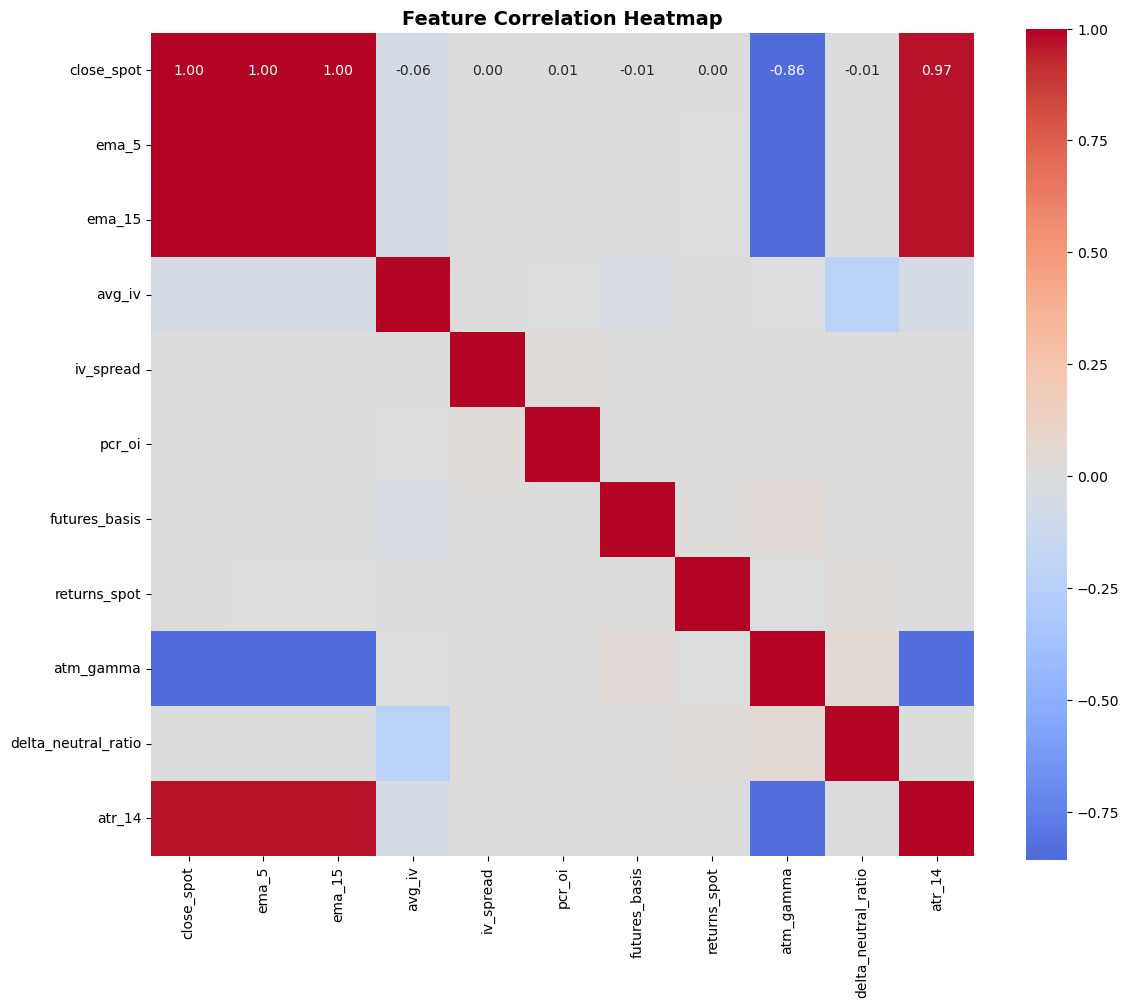

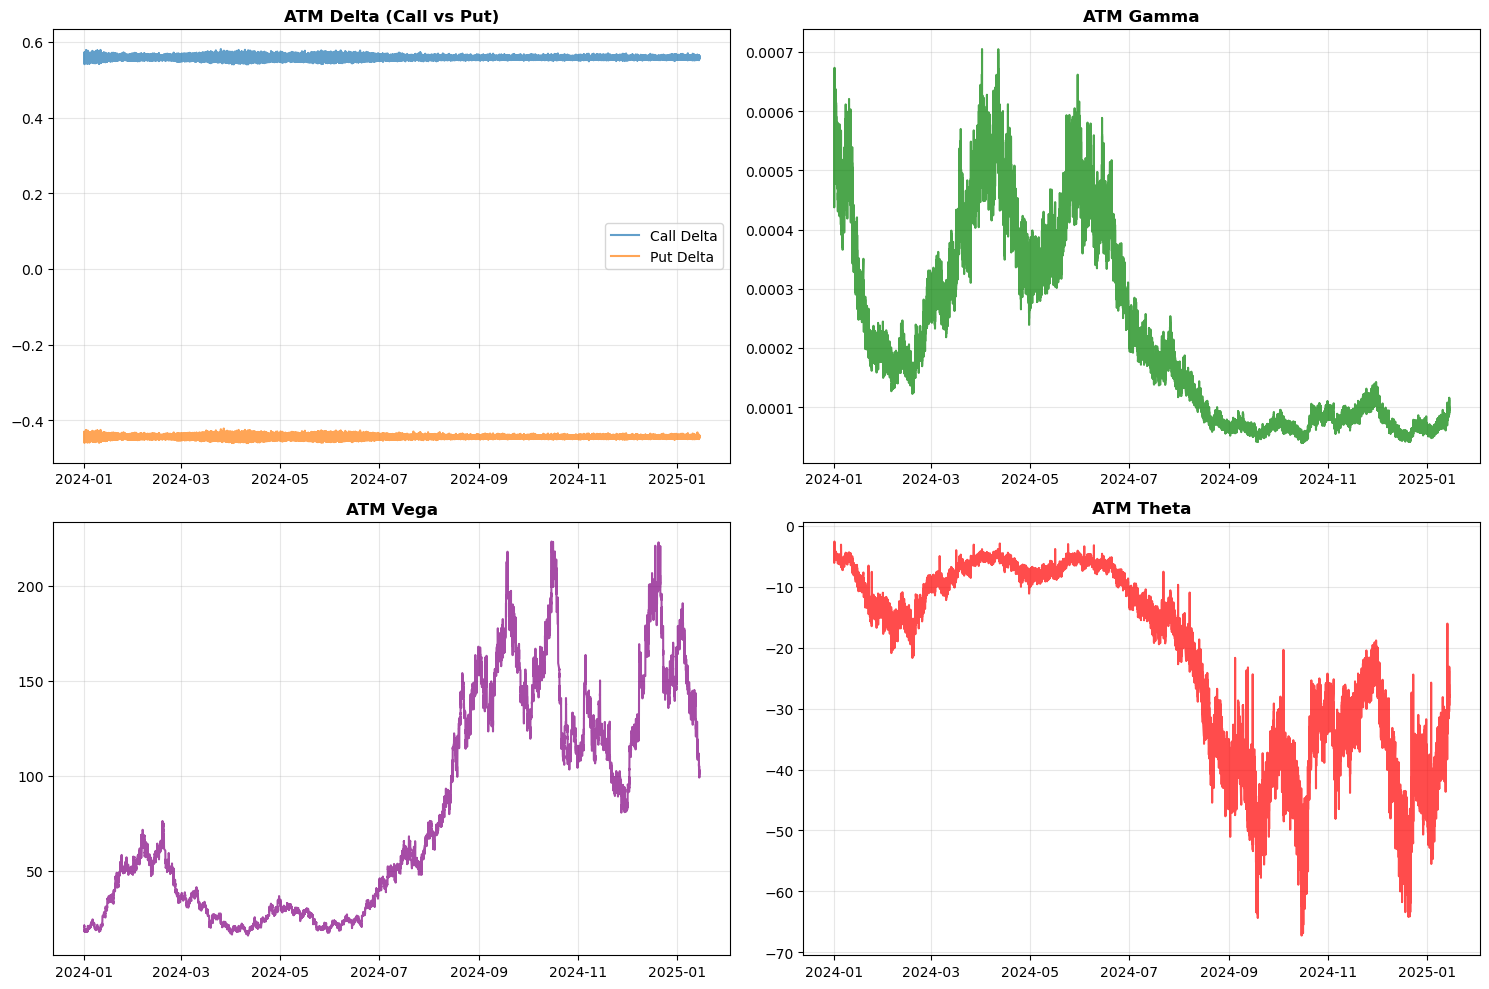

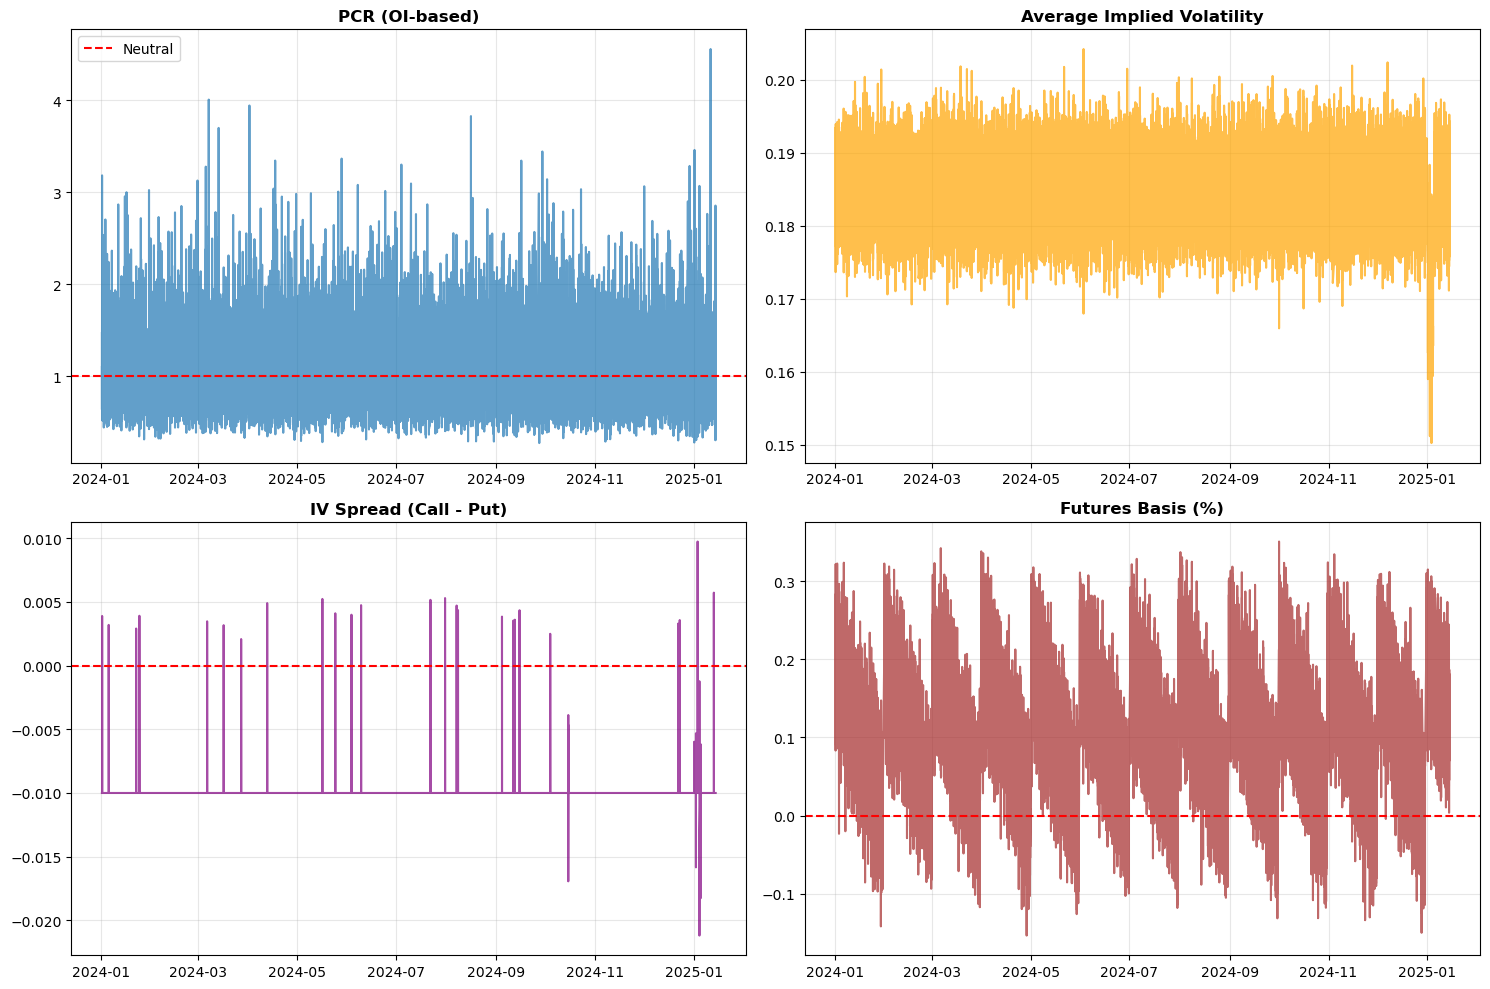

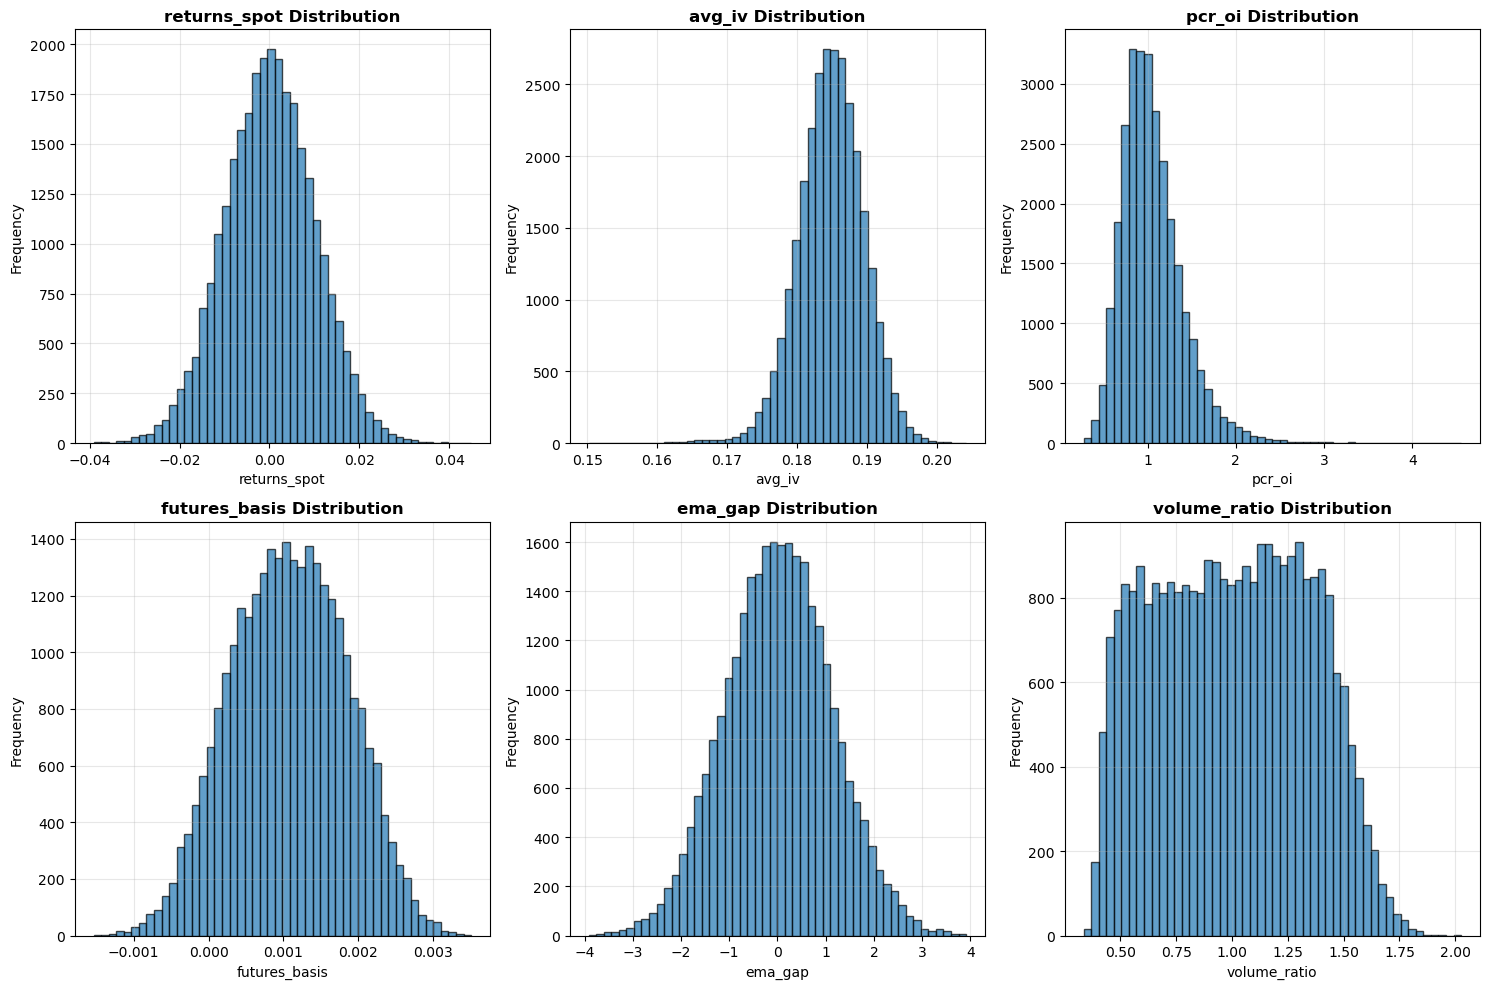

In [18]:
#=============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("CREATING FEATURE VISUALIZATIONS")
print("="*70)

# 1. Correlation Heatmap

fig, ax = plt.subplots(figsize=(12, 10))
correlation_features = ['close_spot', 'ema_5', 'ema_15', 'avg_iv', 'iv_spread',
                       'pcr_oi', 'futures_basis', 'returns_spot', 'atm_gamma',
                       'delta_neutral_ratio', 'atr_14']
corr_matrix = merged_df[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, square=True)
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'feature_correlation.png', dpi=300)
print("✓ Saved: feature_correlation.png")

# 2. Greeks Time Series

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(merged_df['timestamp'], merged_df['atm_call_delta'], 
                label='Call Delta', alpha=0.7)
axes[0, 0].plot(merged_df['timestamp'], merged_df['atm_put_delta'], 
                label='Put Delta', alpha=0.7)
axes[0, 0].set_title('ATM Delta (Call vs Put)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(merged_df['timestamp'], merged_df['atm_gamma'], 
                color='green', alpha=0.7)
axes[0, 1].set_title('ATM Gamma', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(merged_df['timestamp'], merged_df['atm_vega'], 
                color='purple', alpha=0.7)
axes[1, 0].set_title('ATM Vega', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(merged_df['timestamp'], merged_df['atm_theta'], 
                color='red', alpha=0.7)
axes[1, 1].set_title('ATM Theta', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'greeks_timeseries.png', dpi=300)
print("✓ Saved: greeks_timeseries.png")

# 3. PCR and IV Analysis

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(merged_df['timestamp'], merged_df['pcr_oi'], alpha=0.7)
axes[0, 0].axhline(y=1.0, color='r', linestyle='--', label='Neutral')
axes[0, 0].set_title('PCR (OI-based)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(merged_df['timestamp'], merged_df['avg_iv'], 
                color='orange', alpha=0.7)
axes[0, 1].set_title('Average Implied Volatility', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(merged_df['timestamp'], merged_df['iv_spread'], 
                color='purple', alpha=0.7)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_title('IV Spread (Call - Put)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(merged_df['timestamp'], merged_df['futures_basis'] * 100, 
                color='brown', alpha=0.7)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_title('Futures Basis (%)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'pcr_iv_analysis.png', dpi=300)
print("✓ Saved: pcr_iv_analysis.png")

# 4. Feature Distributions

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = ['returns_spot', 'avg_iv', 'pcr_oi', 
                    'futures_basis', 'ema_gap', 'volume_ratio']

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    merged_df[feature].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
    ax.set_title(f'{feature} Distribution', fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'feature_distributions.png', dpi=300)
print("✓ Saved: feature_distributions.png")


In [20]:
# ============================================================================
# DISPLAY SAMPLE DATA
# ============================================================================

print("\n" + "="*70)
print("SAMPLE FEATURES DATA")
print("="*70)

display_cols = ['timestamp', 'close_spot', 'ema_5', 'ema_15', 'avg_iv', 
                'pcr_oi', 'futures_basis', 'atm_gamma', 'returns_spot']

print(merged_df[display_cols].head(10))

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)



SAMPLE FEATURES DATA
            timestamp    close_spot         ema_5        ema_15    avg_iv  \
0 2024-01-01 09:15:00  18091.208548  18091.208548  18091.208548  0.179045   
1 2024-01-01 09:20:00  18068.097832  18083.504976  18088.319708  0.189464   
2 2024-01-01 09:25:00  18187.024105  18118.011352  18100.657758  0.180315   
3 2024-01-01 09:30:00  18465.932526  18233.985077  18146.317104  0.185585   
4 2024-01-01 09:35:00  18424.636212  18297.535455  18181.106992  0.190754   
5 2024-01-01 09:40:00  18383.435276  18326.168729  18206.398028  0.180851   
6 2024-01-01 09:45:00  18675.684186  18442.673881  18265.058798  0.188532   
7 2024-01-01 09:50:00  18820.973195  18568.773652  18334.548097  0.186746   
8 2024-01-01 09:55:00  18734.592949  18624.046751  18384.553704  0.184246   
9 2024-01-01 10:00:00  18838.210666  18695.434723  18441.260824  0.182866   

     pcr_oi  futures_basis  atm_gamma  returns_spot  
0  1.101665       0.001905   0.000515     -0.001277  
1  0.826506       0.00